# Working

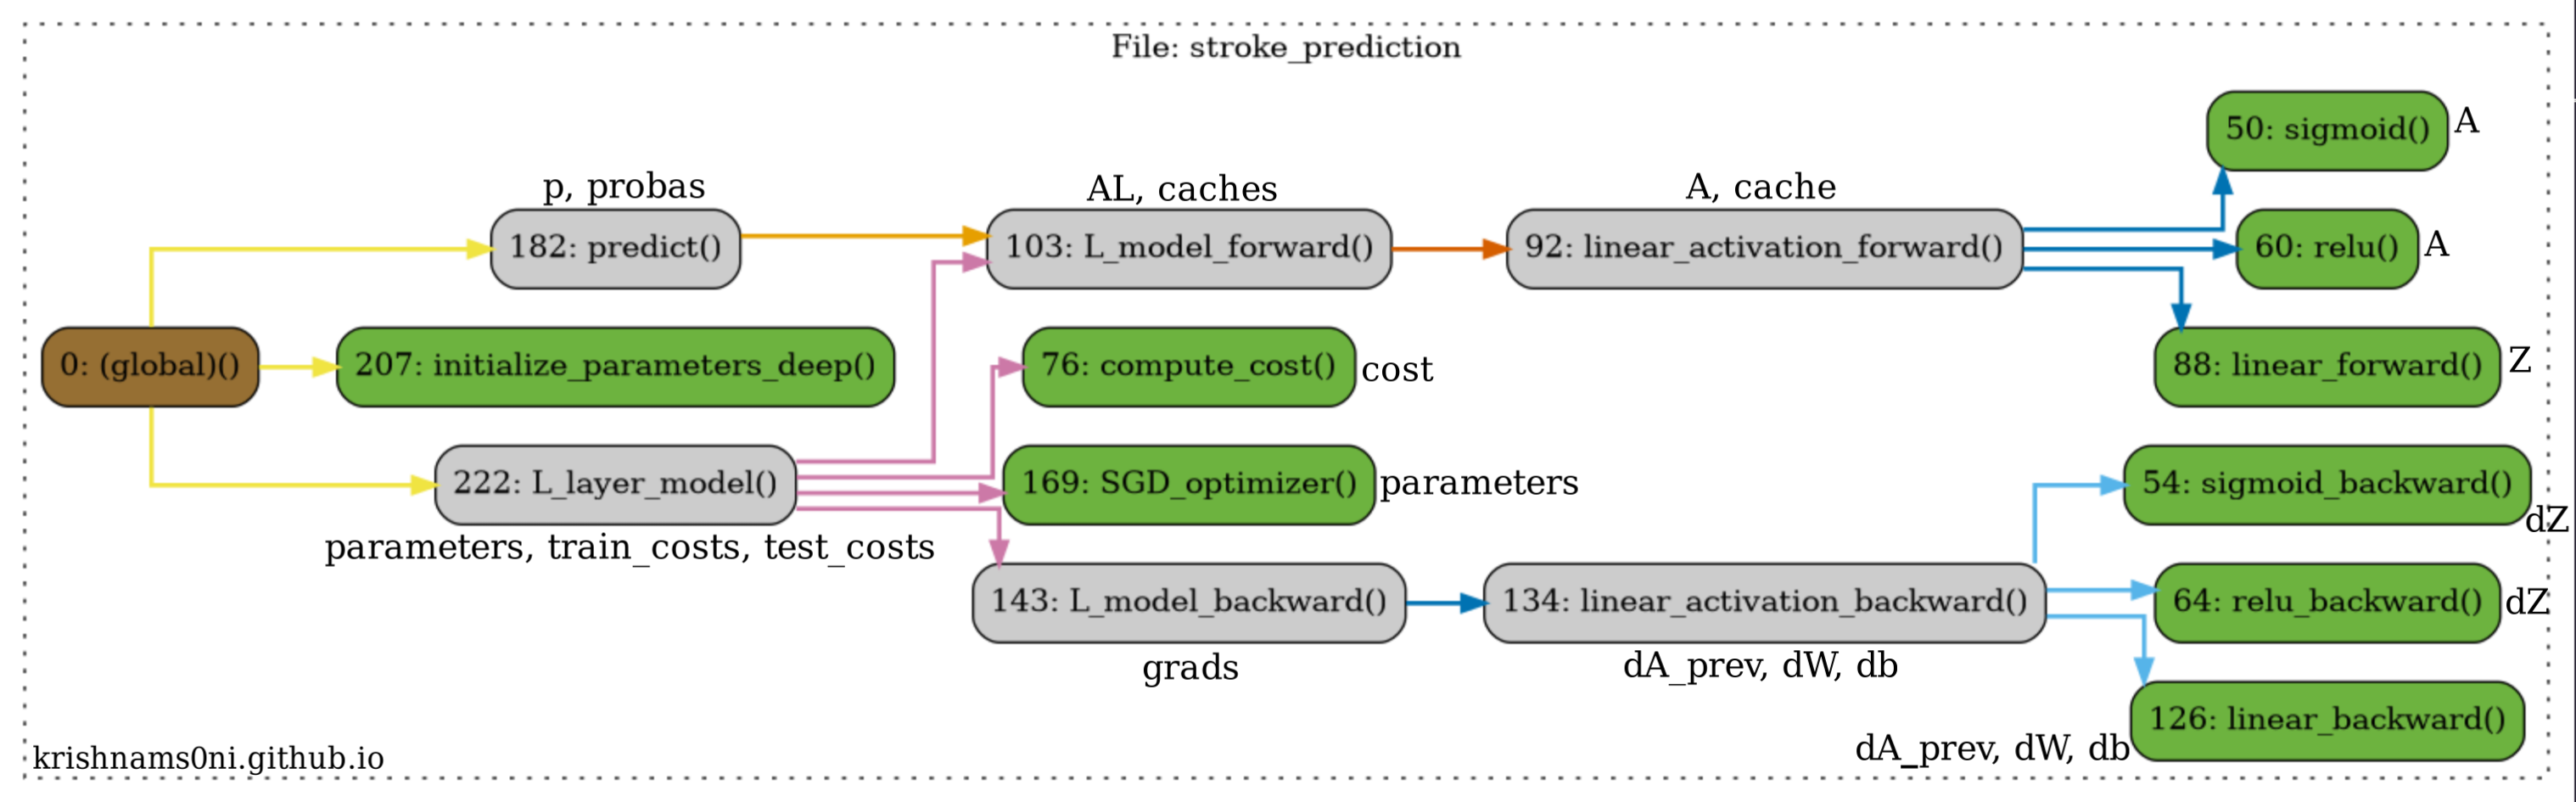

Notes:
- the variables around the functions are the return values of the functions
- parameters have been initialized using He initialization (variant of [Xavier initialization](https://www.deeplearning.ai/ai-notes/initialization/index.html))
- ignore the numbers in the boxes - they are the line numbers of the code, and don't matter
- you can see this same algorithm implemented on another dataset [here](https://www.kaggle.com/code/krishnams0ni/pistachio-classifier-pure-python-90-accuracy)

# Code

### Getting the data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('healthcare-dataset-stroke-data.csv')

df['bmi'] = df['bmi'].fillna(df['bmi'].mean()) # Fill missing BMI values with the mean

# Encode categorical variables
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['work_type'] = df['work_type'].astype('category').cat.codes
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural': 0})
df['smoking_status'] = df['smoking_status'].astype('category').cat.codes

# Define features and target
X = df.drop(columns=['id', 'stroke'])
y = df['stroke']
y = y.values.reshape(-1, 1) # Reshape y to have one column and as many rows as the number of samples

# Split the data into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Transpose the test labels
test_y = test_y.T
train_y = train_y.T
train_x = train_x.T
test_x = test_x.T

print(f'Training features shape: {train_x.shape}')
print(f'Test features shape: {test_x.shape}')
print(f'Training labels shape: {train_y.shape}')
print(f'Test labels shape: {test_y.shape}')

Training features shape: (10, 4088)
Test features shape: (10, 1022)
Training labels shape: (1, 4088)
Test labels shape: (1, 1022)


### Activation Functions with Gradients

In [2]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def sigmoid_backward(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

def relu(Z):
    A = np.maximum(0, Z)
    return A

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

### Binary Cross Entropy Cost Function

In [3]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (1. / m) * (-np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T))
    cost = np.squeeze(cost)
    return cost

### Forward Propagation

In [4]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    return Z

def linear_activation_forward(A_prev, W, b, activation):
    linear_cache = A_prev, W, b
    Z = linear_forward(A_prev, W, b)
    activation_cache = Z
    if activation == "sigmoid":
        A = sigmoid(Z)
    else:
        A = relu(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev,
            parameters['W' + str(l)], parameters['b' + str(l)], activation="relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A,
        parameters['W' + str(L)], parameters['b' + str(L)], activation="sigmoid")
    caches.append(cache)
    
    return AL, caches

### Backpropagation

In [5]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    else:
        dZ = relu_backward(dA, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L - 1]
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads[
        "db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
            grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

### Gradient Descent

In [6]:
def SGD_optimizer(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return parameters

### Predict

In [7]:
def predict(X, y, parameters):
    m = X.shape[1]
    p = np.zeros((1, m))
    
    probas, caches = L_model_forward(X, parameters)
    for i in range(probas.shape[1]):
        p[0, i] = probas[0, i] > 0.5
    return p, probas

### L layer model

In [8]:
n_x = 10
n_h_1 = 3
n_y = 1
layers_dims = (n_x, n_h_1, n_y)

In [9]:
np.random.seed(1)
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * np.sqrt(2 / layer_dims[l - 1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

In [10]:
parameters = initialize_parameters_deep(layers_dims)

def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, print_cost=True, parameters=parameters):
    train_costs = []
    test_costs = []
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        grads = L_model_backward(AL, Y, caches)
        parameters = SGD_optimizer(parameters, grads, learning_rate)
        if i % 10 == 0 or i == num_iterations - 1:
            train_cost = compute_cost(AL, Y)
            test_cost = compute_cost(L_model_forward(test_x, parameters)[0], test_y)
            train_costs.append(train_cost)
            test_costs.append(test_cost)
        if print_cost and i % 500 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {} {}".format(i, np.round(np.squeeze(train_cost), 4), np.round(np.squeeze(test_cost), 4)))
    return parameters, train_costs, test_costs

In [11]:
%%time
parameters, train_costs, test_costs = L_layer_model(train_x, train_y, layers_dims, learning_rate=0.01, num_iterations=3000)

Cost after iteration 0: 0.6837 0.7084
Cost after iteration 500: 0.2951 0.3156
Cost after iteration 1000: 0.2254 0.2544
Cost after iteration 1500: 0.2038 0.2374
Cost after iteration 2000: 0.195 0.2317
Cost after iteration 2500: 0.1908 0.2296
Cost after iteration 2999: 0.1887 0.229
CPU times: user 1.62 s, sys: 2.43 ms, total: 1.63 s
Wall time: 1.62 s


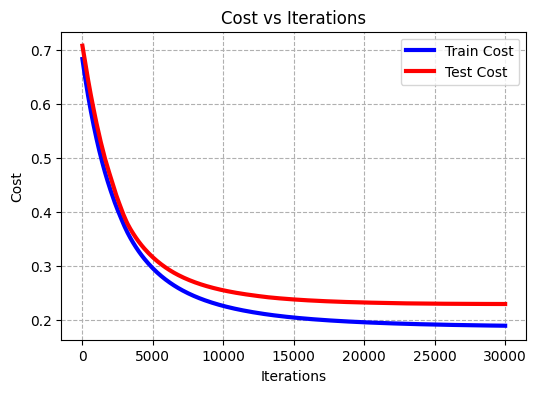

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
iterations = range(1, len(train_costs) * 100, 100)
plt.plot(iterations, train_costs, color='blue', linewidth=3, label='Train Cost')
plt.plot(iterations, test_costs, color='red', linewidth=3, label='Test Cost')
plt.xlabel('Iterations', fontsize=10)
plt.ylabel('Cost', fontsize=10)
plt.title('Cost vs Iterations', fontsize=12)
plt.grid(True, linestyle='--')
plt.legend(loc='upper right', fontsize=10)
plt.show()

In [13]:
pred_train = predict(train_x, train_y, parameters)
m = train_x.shape[1]
print("Training accuracy: " + str(np.sum((pred_train == train_y) / m) * 100)[:7] + " %")

pred_test = predict(test_x, test_y, parameters)
m = test_x.shape[1]
print("Test accuracy: " + str(np.sum((pred_test == test_y) / m) * 100)[:7] + " %")

Training accuracy: 95.4256 %
Test accuracy: 93.9334 %
